In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadCSVData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN
from commonModel import limitDataUsingProcentiles, limitDataUsingLimitsFromFilename

#dataFileName   = "input/NizhnyNovgorodWithYear.csv"
#limitsFileName = "input/NizhnyNovgorodLimits.json"

dataFileName   = "input/SaintPetersburg.csv"
limitsFileName = "input/SaintPetersburgLimits.json"

#dataFileName   = "input/Moscow.csv"
#limitsFileName = "input/MoscowLimits.json"


allDataFrame = loadCSVData( dataFileName, COLUMN_TYPE='NUMERICAL' )
allDataFrame = limitDataUsingLimitsFromFilename( allDataFrame, limitsFileName )
allDataFrame = limitDataUsingProcentiles       ( allDataFrame )
#allDataFrame = inputDataFrame[FEATURES]
allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/sergey/My_trash/GEO_GID/commonModel.py:57: SettingWithCopyWarn

,price,longitude,latitude,total_square,number_of_rooms,number_of_floors,exploitation_start_year,distance_from_metro
0,12000000.0,30.263056,59.880405,118.0,4,7,0.0,101.644012
1,7350000.0,30.381975,59.834003,60.7,2,24,0.0,584.970947
2,3750000.0,30.474745,59.950268,45.4,2,16,0.0,2794.552246
4,3800000.0,30.425659,60.031742,34.8,1,16,0.0,546.165894
5,3830000.0,30.408592,59.718521,42.4,2,3,0.0,15265.827148
7,6500000.0,30.258707,60.003265,56.0,2,12,0.0,591.317932
8,5000000.0,30.370810,59.809143,60.0,2,25,0.0,2307.093750
9,5600000.0,30.226089,60.036957,54.5,2,13,0.0,3629.985107
10,2800000.0,30.362528,59.842793,78.0,2,16,0.0,1287.653442
11,4500000.0,30.356625,59.839638,94.0,3,23,0.0,815.694702


In [2]:
allDataFrame.describe()

,price,longitude,latitude,total_square,number_of_rooms,number_of_floors,exploitation_start_year,distance_from_metro
count,97922.00,97922.000000,97922.000000,97922.000000,97922.000000,97922.000000,97922.0,97922.000000
mean,6877154.00,30.324957,59.931709,64.057733,2.059108,14.200425,0.0,3111.273438
std,4203024.50,0.119782,0.087410,30.907736,1.017308,7.213465,0.0,4526.644531
min,990000.00,29.509441,59.661709,18.000000,1.000000,1.000000,0.0,0.000000
25%,4165943.75,30.259157,59.862418,42.235000,1.000000,9.000000,0.0,849.768555
50%,5700000.00,30.328435,59.936638,57.400000,2.000000,13.000000,0.0,1534.042786
75%,8200000.00,30.397516,59.997257,76.400000,3.000000,20.000000,0.0,3165.155273
max,72448000.00,30.746223,60.226524,480.000000,10.000000,45.000000,0.0,56925.355469


In [3]:
import torch
import _pickle as cPickle
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
Model         = None
Features      = None
preprocessorX = None
preprocessorY = None
with open( "modelSaintPetersburg.pkl", 'rb') as fid:
    ModelPacket = cPickle.load(fid)
    Model         = ModelPacket['model'        ]
    Features      = ModelPacket['features'     ]
    preprocessorX = ModelPacket['preprocessorX']
    preprocessorY = ModelPacket['preprocessorY']
index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       
Y_values    = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); 
X_dataFrame = X_dataFrame[ Features ]

X_values    = X_dataFrame.values
Y_values    = Y_values

X_numpy = preprocessorX.transform( X_values )
Y_numpy = preprocessorY.transform( Y_values )

X_torch = torch.from_numpy( X_numpy.astype( np.float32 ) ).to( device )
Y_torch = Model( X_torch )
Y_predict = Y_torch.detach().numpy()

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_numpy, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_numpy, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_numpy, Y_predict ) )

Y_predict = preprocessorY.inverse_transform( Y_predict ).ravel()
Y_values  = Y_values.ravel()

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )

Errors on the test set
mean square:      0.004912852
mean absolute:    0.02552526
median_absolute:  0.008664727
Errors on the test set
mean square:      4806308500000.0
mean absolute:    798379.06
median_absolute:  271015.5


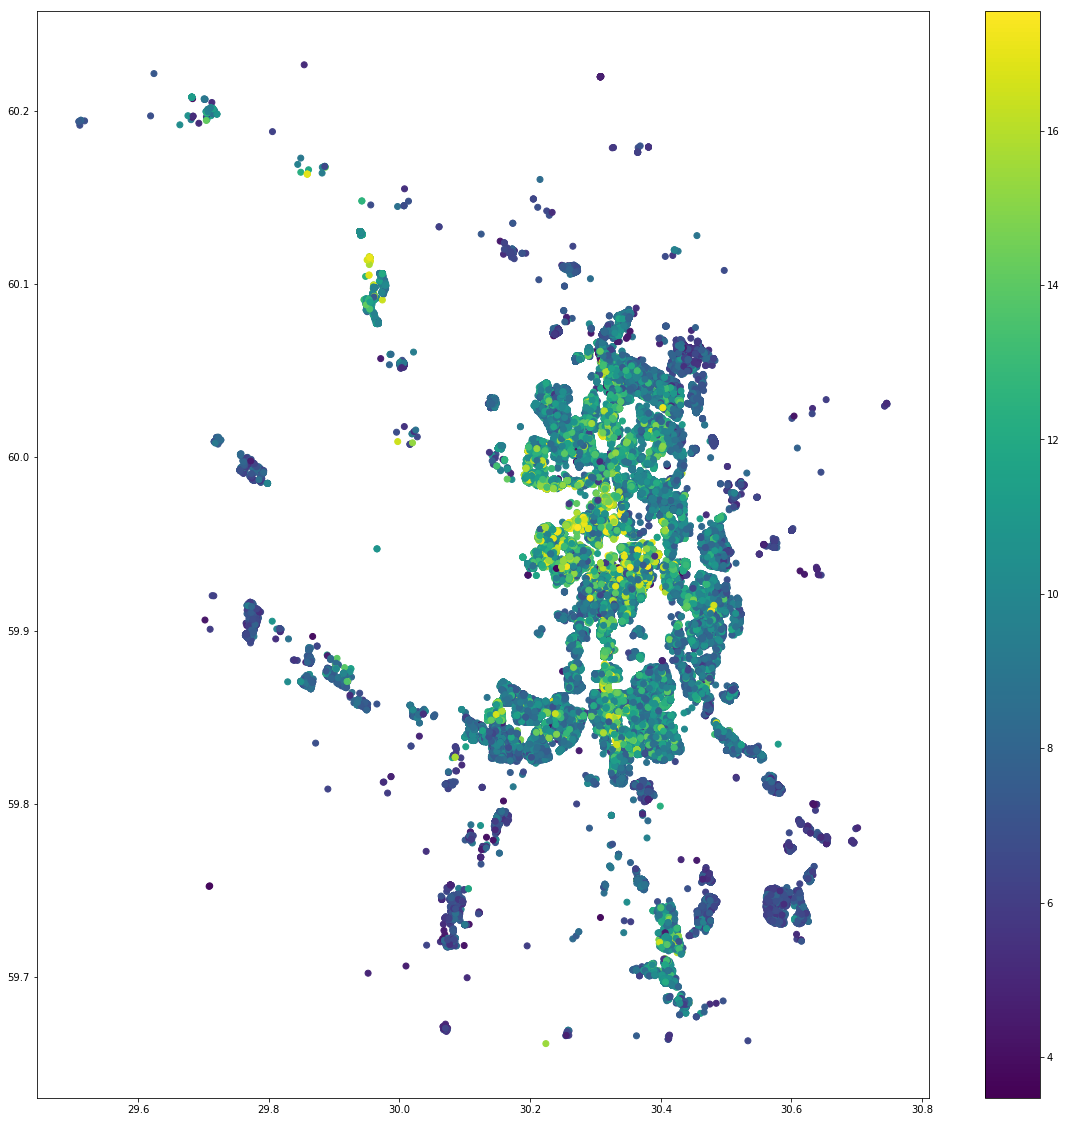

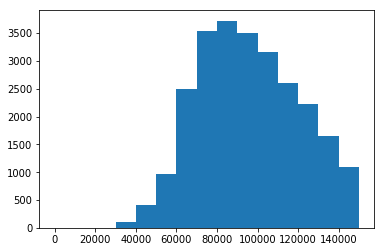

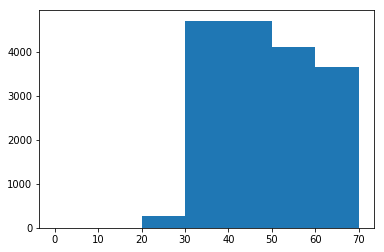

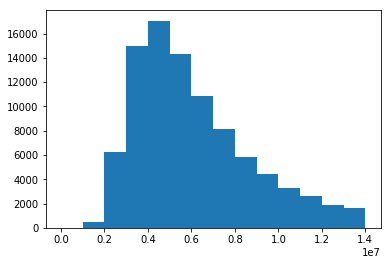

In [4]:
pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
TotalSquare          = allDataFrame['total_square']
Price                = allDataFrame['price']

pricePerSquareValues = pricePerSquare.values
TotalSquareValues    = TotalSquare.values
PriceValues          = Price.values

x = X_values[:,0]; y = X_values[:,1];

plt.figure(figsize=(20,20))
plt.scatter (x, y, c=pricePerSquareValues/10000  )
plt.colorbar()
plt.show()

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
mask = Y_relErr > 10
pricePerSquareValues = pricePerSquareValues[ mask ]
TotalSquareValues    = TotalSquareValues   [ mask ]
Price                = Price               [ mask ]

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.]
bins = [i * 1e4 for i in bins]
plt.hist( pricePerSquareValues, bins=bins )
plt.show()

bins = [0,10,20,30,40,50,60,70]
plt.hist( TotalSquareValues, bins=bins )
plt.show()

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.]
bins = [i * 1e6 for i in bins]
plt.hist( PriceValues      , bins=bins )
plt.show()


[10934121.   7231188.   4450327.  ...  4846995.5  3080843.   4960647.5]
[12000000.  7350000.  3750000. ...  6000000.  3350000.  4621782.]
price                      7.200000e+07
longitude                  3.021188e+01
latitude                   5.995361e+01
total_square               4.800000e+02
number_of_rooms            3.000000e+00
number_of_floors           1.000000e+01
exploitation_start_year    0.000000e+00
distance_from_metro        1.376719e+03
Name: 126574, dtype: float64
(672,)
threshold =   2.5, good =      32831, bad =      65091, err = 0.6647229427503524
threshold =   5.0, good =      50658, bad =      47264, err = 0.4826698801086579
threshold =  10.0, good =      70079, bad =      27843, err = 0.2843385551765691
threshold =  15.0, good =      79604, bad =      18318, err = 0.18706725761320234


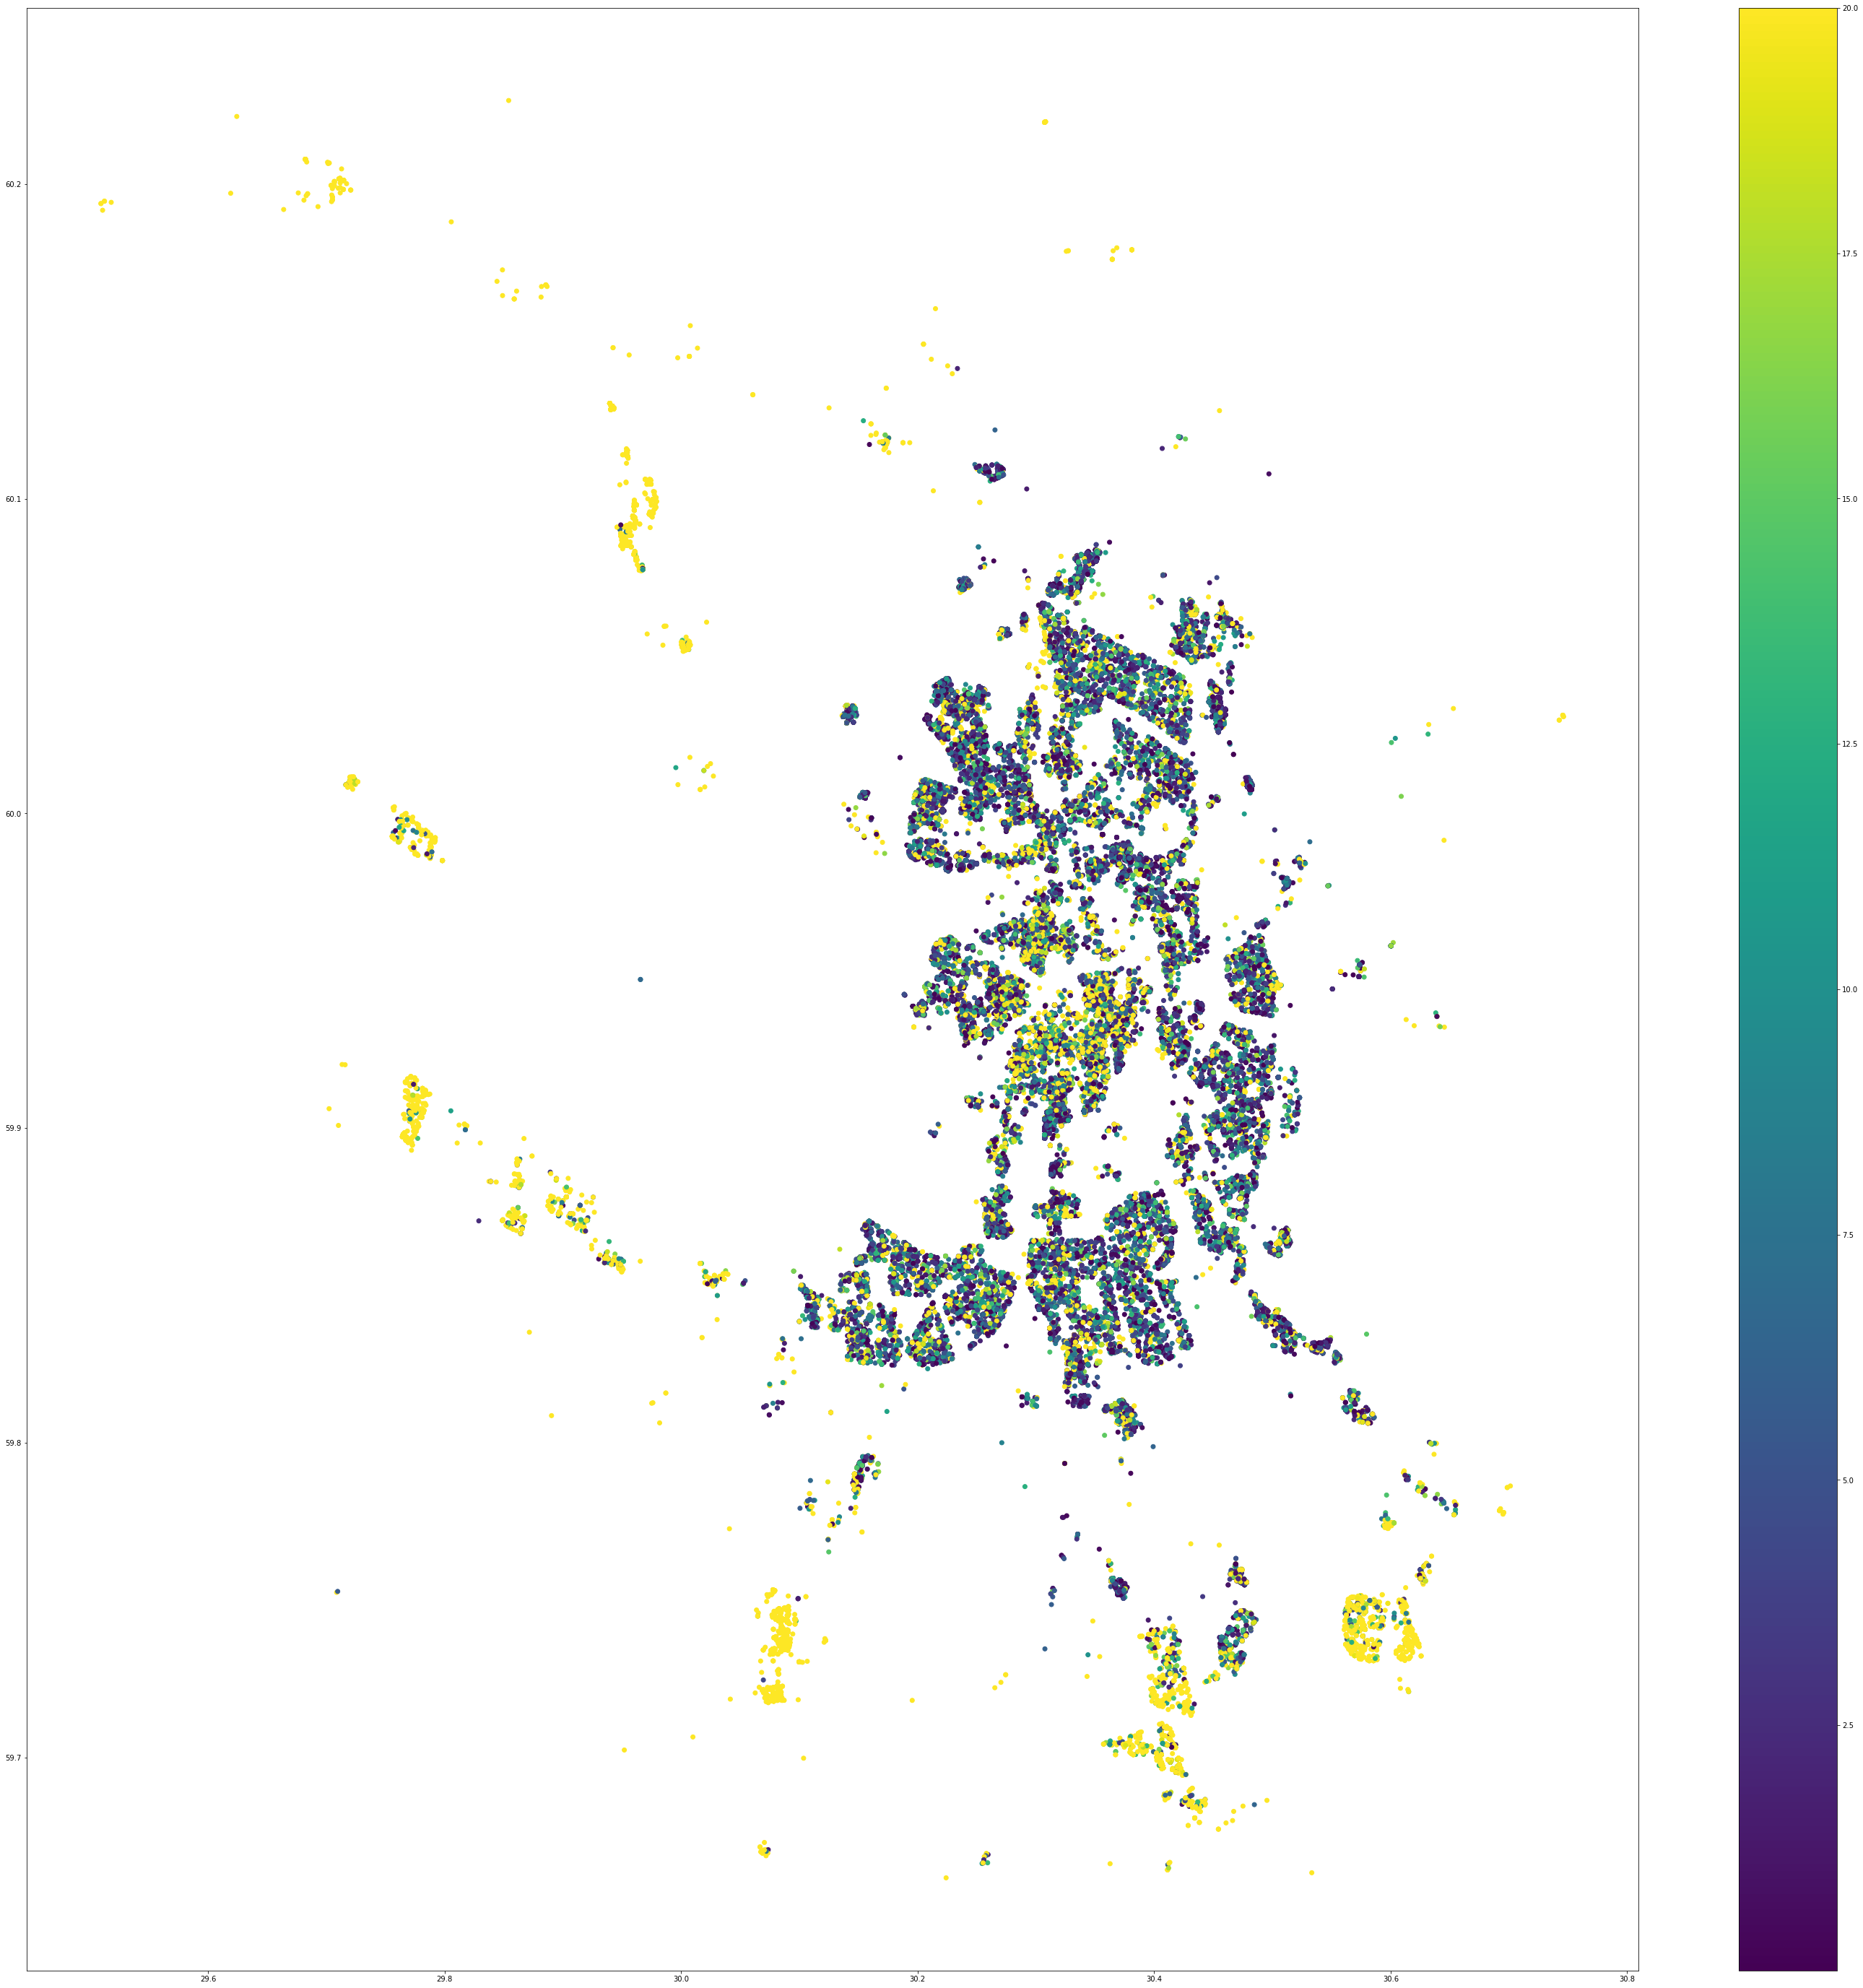

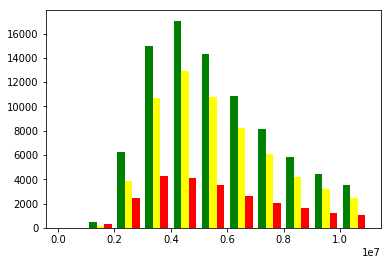

[    1   472  6264 14980 17056 14293 10888  8150  5821  4438  3505]
[    1   136  3843 10684 12918 10765  8229  6084  4178  3225  2477]
[   0  336 2421 4296 4138 3528 2659 2066 1643 1213 1028]


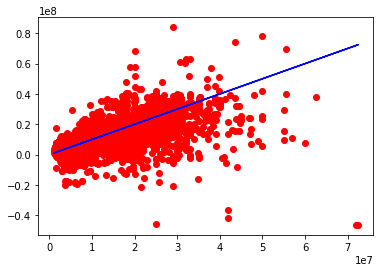

In [8]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

print( Y_predict )
print( Y_values  )

print( allDataFrame.iloc[40573] )

print( Y_predict[Y_predict < 0].shape )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0, 15.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 20 );

plt.figure(figsize=(50,50))
plt.scatter (x, y, c=c  )
plt.colorbar()
plt.show()
"""
mask = ( Y_values < 1e6 ) & ( Y_relErr > 10 )
x_low = X_values[mask,0]; y_low = X_values[mask,1]; c_low = 'red'
plt.scatter (x_low, y_low, c=c_low, marker="*", s=75  )

mask = ( Y_values > 5e6 ) & ( Y_relErr > 10 )
x_high = X_values[mask,0]; y_high = X_values[mask,1]; c_high = 'aqua'
plt.scatter (x_high, y_high, c=c_high, marker="*", s=75  )
plt.show    ()
"""
threshold = 10
allTestDataValues  = testDataFrame.price.values
mask = Y_relErr >  threshold
badTestDataValues = testDataFrame[ mask ].price.values
mask = Y_relErr <= threshold
goodTestDataValues = testDataFrame[ mask ].price.values

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.]
bins = [i * 1e6 for i in bins]

n = plt.hist([ allTestDataValues, goodTestDataValues, badTestDataValues ], bins=bins, histtype='bar', color=['green','yellow','red'])
plt.show()

print( n[0][0].astype(np.int64) )
print( n[0][1].astype(np.int64) )
print( n[0][2].astype(np.int64) )

plt.scatter(Y_values,Y_predict, color='red' )
plt.plot   (Y_values,Y_values , color='blue')
plt.show   ()

In [6]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

ImportError: cannot import name 'MAX_LONGITUDE'